# FLIGHT OPERATIONS ANALYSIS & DIFFICULTY SCORING (R Version)

In [1]:
library(tidyverse)
library(lubridate)
library(corrplot)

print("Initializing Analysis in R")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
corrplot 0.95 loaded



[1] "Initializing Analysis in R"




### PHASE 1: BUSINESS UNDERSTANDING

GOAL: 

Analyze flight operations to identify complexity drivers and develop a
"Flight Difficulty Score" for proactive resource management.


DELIVERABLES:
1. Exploratory Data Analysis (EDA).
2. A daily Flight Difficulty Score.
3. Actionable operational insights.



### PHASE 2: DATA UNDERSTANDING

In [2]:

# PHASE 2: DATA UNDERSTANDING


print("[Phase 2/6] Loading datasets...")
tryCatch({
  flight_df <- read_csv('Flight Level Data.csv', show_col_types = FALSE)
  pnr_flight_df <- read_csv('PNR+Flight+Level+Data.csv', show_col_types = FALSE)
  pnr_remark_df <- read_csv('PNR Remark Level Data.csv', show_col_types = FALSE)
  bag_df <- read_csv('Bag+Level+Data.csv', show_col_types = FALSE)
  airports_df <- read_csv('Airports Data.csv', show_col_types = FALSE)
  print("All data files loaded successfully.")
}, error = function(e) {
  stop("Error loading files. Please ensure all 5 CSV files are in the same directory.")
})

[1] "[Phase 2/6] Loading datasets..."
[1] "All data files loaded successfully."


[1] "Performing initial data understanding... (Displaying Plots)"


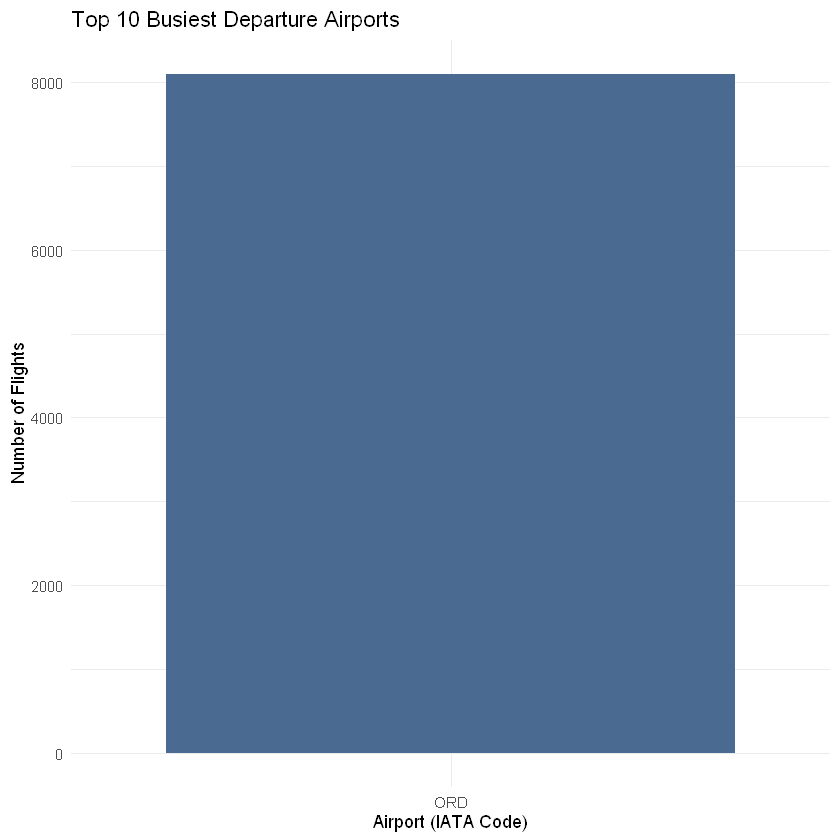

In [3]:
# Initial Exploration & Visualizations
print("Performing initial data understanding... (Displaying Plots)")

# Top 10 Departure Airports
viz_top_airports <- flight_df %>%
  count(scheduled_departure_station_code, sort = TRUE) %>%
  top_n(10, n) %>%
  ggplot(aes(x = reorder(scheduled_departure_station_code, -n), y = n)) +
  geom_bar(stat = "identity", fill = "#4A6A92") +
  labs(title = "Top 10 Busiest Departure Airports",
       x = "Airport (IATA Code)", y = "Number of Flights") +
  theme_minimal()
print(viz_top_airports)



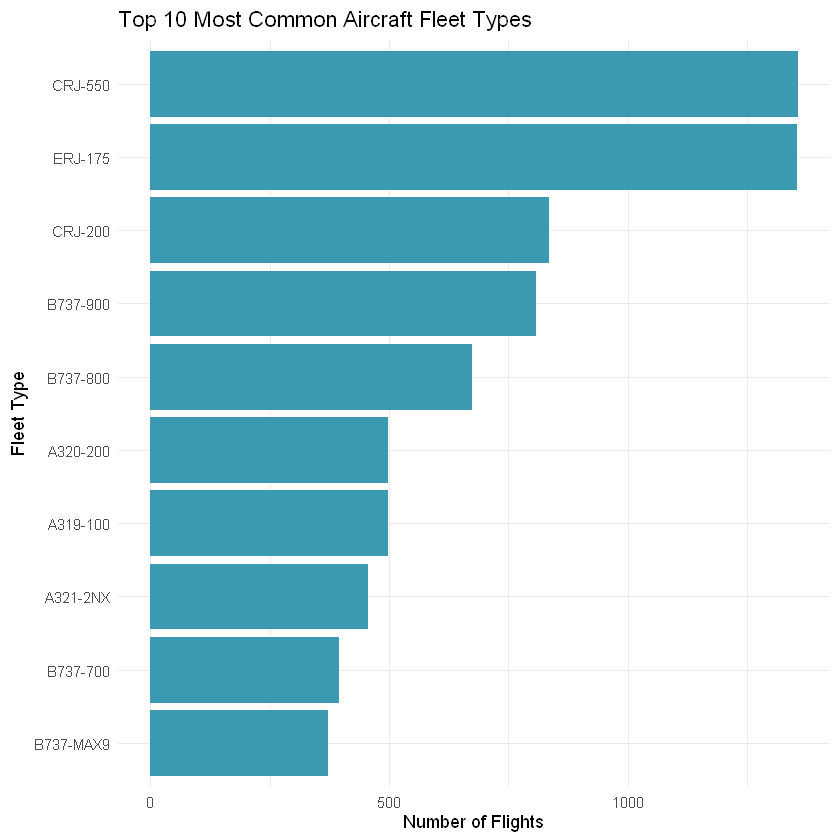

In [4]:

# Distribution of Fleet Types
viz_top_fleet <- flight_df %>%
  count(fleet_type, sort = TRUE) %>%
  top_n(10, n) %>%
  ggplot(aes(x = reorder(fleet_type, n), y = n)) +
  geom_bar(stat = "identity", fill = "#3B9AB2") +
  coord_flip() +
  labs(title = "Top 10 Most Common Aircraft Fleet Types",
       x = "Fleet Type", y = "Number of Flights") +
  theme_minimal()
print(viz_top_fleet)


### PHASE 3: DATA PREPARATION


In [5]:

# PHASE 3: DATA PREPARATION


print("[Phase 3/6] Preparing and engineering features from data...")

# Convert date/time columns
flight_df <- flight_df %>%
  mutate(across(contains("datetime"), ymd_hms),
         scheduled_departure_date_local = ymd(scheduled_departure_date_local))
pnr_flight_df <- pnr_flight_df %>%
  mutate(across(contains("date"), ymd))
pnr_remark_df <- pnr_remark_df %>%
  mutate(pnr_creation_date = ymd(pnr_creation_date))
bag_df <- bag_df %>%
  mutate(across(contains("date"), ymd))

# Define a unique flight identifier
flight_identifier <- c('company_id', 'flight_number', 'scheduled_departure_date_local')

# Engineer features
flight_df <- flight_df %>%
  mutate(
    departure_delay = as.numeric(difftime(actual_departure_datetime_local, scheduled_departure_datetime_local, units = "mins")),
    ground_time_pressure = minimum_turn_minutes - scheduled_ground_time_minutes,
    scheduled_flight_duration = as.numeric(difftime(scheduled_arrival_datetime_local, scheduled_departure_datetime_local, units = "mins"))
  )

# Aggregate data
pnr_agg <- pnr_flight_df %>%
  group_by(!!!syms(flight_identifier)) %>%
  summarise(
    total_pax = sum(total_pax, na.rm = TRUE),
    children_count = sum(is_child == 'Y', na.rm = TRUE),
    lap_child_count = sum(lap_child_count, na.rm = TRUE),
    .groups = "drop"
  )

ssr_agg <- pnr_flight_df %>%
  select(all_of(flight_identifier), record_locator, pnr_creation_date) %>%
  distinct() %>%
  inner_join(pnr_remark_df, by = c("record_locator", "pnr_creation_date", "flight_number")) %>%
  count(!!!syms(flight_identifier), name = "ssr_count")

bag_agg <- bag_df %>%
  count(!!!syms(flight_identifier), bag_type) %>%
  pivot_wider(names_from = bag_type, values_from = n, values_fill = 0) %>%
  rename(checked_bags = Origin, transfer_bags = Transfer)

# Merge into a master DataFrame
df <- flight_df %>%
  left_join(pnr_agg, by = flight_identifier) %>%
  left_join(ssr_agg, by = flight_identifier) %>%
  left_join(bag_agg, by = flight_identifier)

# Handle nulls and create final features
df <- df %>%
  mutate(across(c(total_pax, children_count, lap_child_count, ssr_count, checked_bags, transfer_bags), ~replace_na(., 0))) %>%
  filter(!is.na(departure_delay), !is.na(total_seats), total_seats > 0) %>%
  mutate(
    load_factor = pmin(total_pax / total_seats, 1),
    transfer_bag_ratio = transfer_bags / (checked_bags + transfer_bags)
  ) %>%
  mutate(transfer_bag_ratio = if_else(is.nan(transfer_bag_ratio), 0, transfer_bag_ratio))

print("Preprocessing complete.")


[1] "[Phase 3/6] Preparing and engineering features from data..."
[1] "Preprocessing complete."


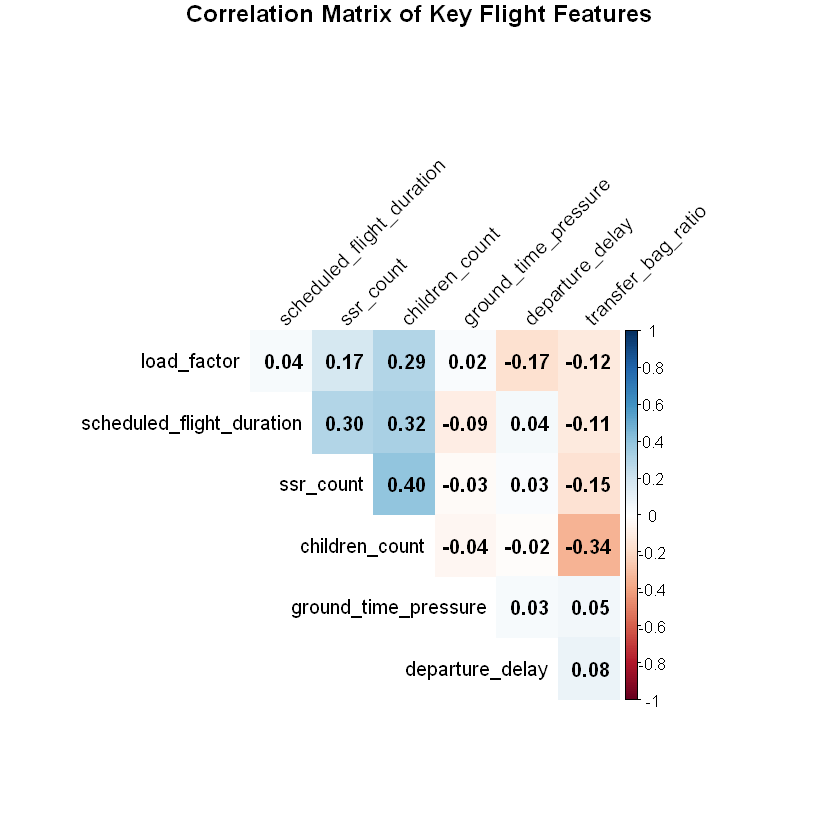

In [6]:

# Correlation Heatmap
corr_features <- c('departure_delay', 'load_factor', 'ssr_count', 'transfer_bag_ratio', 'children_count', 'ground_time_pressure', 'scheduled_flight_duration')
correlation_matrix <- cor(df[corr_features], use = "complete.obs")
corrplot(correlation_matrix, method = "color", type = "upper", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45, diag = FALSE,
         title = "Correlation Matrix of Key Flight Features", mar=c(0,0,1,0))



### PHASE 4: MODELING (EDA & Difficulty Score)

[1] "[Phase 4/6] Answering EDA Questions and Building Difficulty Score..."

EDA Insights
1. Average Delay: 47.06 minutes for late flights.
   Percentage of Late Flights: 49.61%
2. Flights with Tight Schedules: 652 flights have ground time at or below the minimum.
3. Bag Ratio: The average ratio of transfer to checked bags is 3.04.
4. Load Factor vs. Delay: The correlation is -0.17, indicating a very weak relationship.
5. SSRs vs. Delay: The p-value for SSRs is 0.00, which is not statistically significant.
----------------------
[1] "Daily difficulty score, ranking, and classification complete."


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


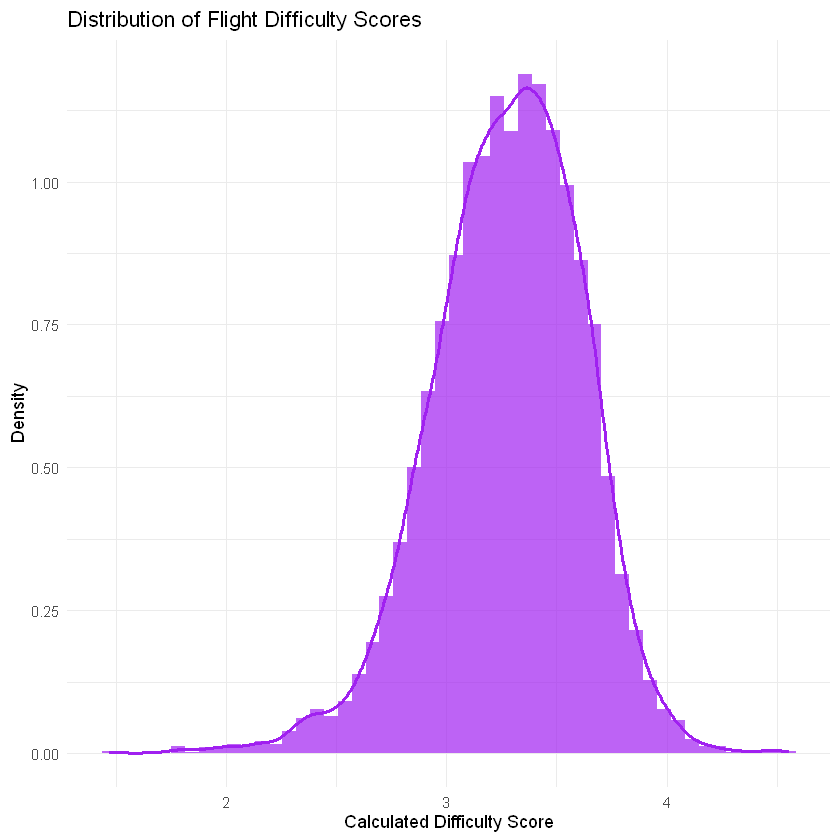

In [7]:


# PHASE 4: MODELING (EDA & Difficulty Score)


print("[Phase 4/6] Answering EDA Questions and Building Difficulty Score...")
cat("\nEDA Insights\n")
# Q1
delayed_flights <- filter(df, departure_delay > 0)
cat(sprintf("1. Average Delay: %.2f minutes for late flights.\n", mean(delayed_flights$departure_delay, na.rm = TRUE)))
cat(sprintf("   Percentage of Late Flights: %.2f%%\n", nrow(delayed_flights) / nrow(df) * 100))
# Q2
tight_schedule_flights <- filter(df, ground_time_pressure >= 0)
cat(sprintf("2. Flights with Tight Schedules: %d flights have ground time at or below the minimum.\n", nrow(tight_schedule_flights)))
# Q3
bag_ratio_df <- filter(df, checked_bags > 0) %>% mutate(ratio = transfer_bags / checked_bags)
cat(sprintf("3. Bag Ratio: The average ratio of transfer to checked bags is %.2f.\n", mean(bag_ratio_df$ratio, na.rm=TRUE)))
# Q4
cat(sprintf("4. Load Factor vs. Delay: The correlation is %.2f, indicating a very weak relationship.\n", cor(df$load_factor, df$departure_delay, use="complete.obs")))
# Q5
model <- lm(departure_delay ~ load_factor + ssr_count, data = df)
cat(sprintf("5. SSRs vs. Delay: The p-value for SSRs is %.2f, which is not statistically significant.\n", summary(model)$coefficients["ssr_count", "Pr(>|t|)"]))
cat("----------------------\n")

# DELIVERABLE 2: FLIGHT DIFFICULTY SCORE DEVELOPMENT
difficulty_features <- c('load_factor', 'ssr_count', 'transfer_bag_ratio', 'children_count', 'ground_time_pressure')
weights <- c(1, 1.5, 1.2, 0.8, 1.5)

# Min-Max Scaling
min_max_scale <- function(x) { (x - min(x, na.rm=T)) / (max(x, na.rm=T) - min(x, na.rm=T)) }
df_normalized <- df %>% mutate(across(all_of(difficulty_features), min_max_scale))

# Calculate weighted score
df$difficulty_score <- as.matrix(df_normalized[difficulty_features]) %*% weights

# Rank and classify
df <- df %>%
  group_by(scheduled_departure_date_local) %>%
  mutate(
    daily_rank = rank(-difficulty_score, ties.method = "first"),
    difficulty_class = case_when(
      daily_rank <= quantile(daily_rank, 0.25) ~ "Difficult",
      daily_rank > quantile(daily_rank, 0.75) ~ "Easy",
      TRUE ~ "Medium"
    )
  ) %>%
  ungroup()
print("Daily difficulty score, ranking, and classification complete.")

# Visualization of Difficulty Score
viz_score_dist <- ggplot(df, aes(x = difficulty_score)) +
  geom_histogram(bins = 50, aes(y=..density..), fill = "purple", alpha = 0.7) +
  geom_density(color = "purple", size = 1) +
  labs(title = "Distribution of Flight Difficulty Scores", x = "Calculated Difficulty Score", y = "Density") +
  theme_minimal()
print(viz_score_dist)



### PHASE 5: EVALUATION

[1] "[Phase 5/6] Evaluating the Difficulty Score..."


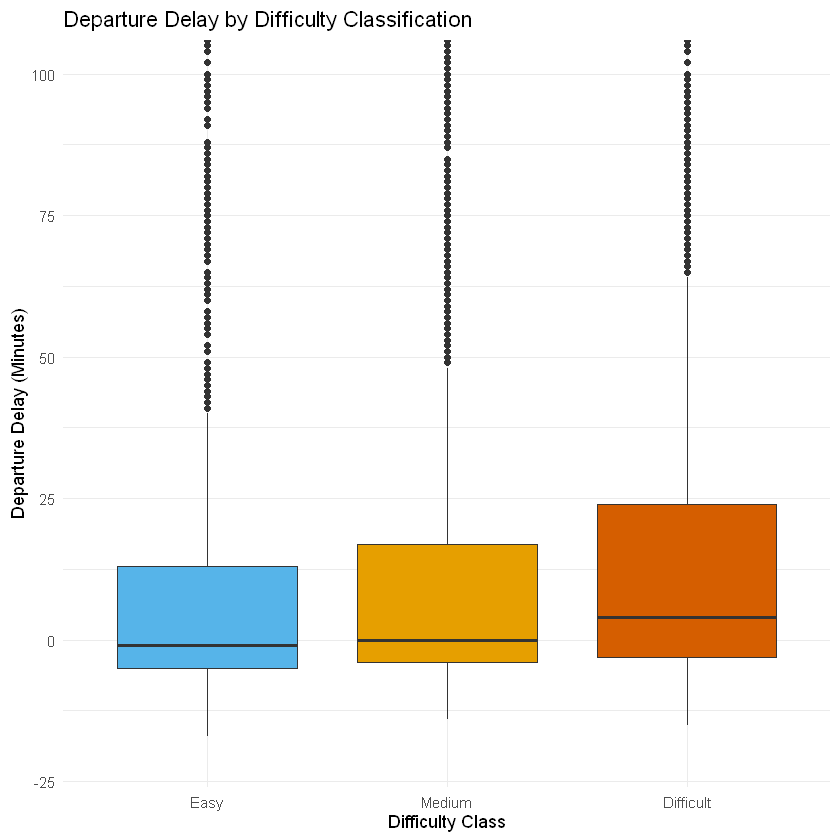

In [8]:


# PHASE 5: EVALUATION


print("[Phase 5/6] Evaluating the Difficulty Score...")
df$difficulty_class <- factor(df$difficulty_class, levels = c("Easy", "Medium", "Difficult"))
viz_eval <- ggplot(df, aes(x = difficulty_class, y = departure_delay, fill = difficulty_class)) +
  geom_boxplot() +
  scale_fill_manual(values = c("Easy" = "#56B4E9", "Medium" = "#E69F00", "Difficult" = "#D55E00")) +
  coord_cartesian(ylim = c(-20, 100)) +
  labs(title = "Departure Delay by Difficulty Classification", x = "Difficulty Class", y = "Departure Delay (Minutes)") +
  theme_minimal() + theme(legend.position = "none")
print(viz_eval)




### PHASE 6: DEPLOYMENT (INSIGHTS)

[1] "[Phase 6/6] Generating Final Insights and Recommendations..."

Operational Insights
1. Top 5 Most Consistently Difficult Destinations:
# A tibble: 6 × 2
  scheduled_arrival_station_code count
  <chr>                          <int>
1 STL                               66
2 GRR                               57
3 MSN                               52
4 CID                               47
5 DSM                               46
6 SBN                               46


Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `across(all_of(difficulty_features), mean, na.rm = TRUE)`.
ℹ In group 1: `scheduled_arrival_station_code = "CID"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"



2. Common Drivers for Top Difficult Destinations (Average Values):
# A tibble: 6 × 6
  scheduled_arrival_st…¹ load_factor ssr_count transfer_bag_ratio children_count
  <chr>                        <dbl>     <dbl>              <dbl>          <dbl>
1 CID                           0.98      1.28               0.93           3.4 
2 DSM                           0.99      2.35               0.84           4.17
3 GRR                           0.97      1.95               0.93           3.23
4 MSN                           0.97      1.62               0.95           2.23
5 SBN                           0.96      1.39               0.97           1.37
6 STL                           0.99      2.05               0.88           3.82
# ℹ abbreviated name: ¹​scheduled_arrival_station_code
# ℹ 1 more variable: ground_time_pressure <dbl>

3. Recommendations for Better Operational Efficiency:
   - Proactive Resource Allocation: Use the daily 'Difficult' classification to pre-allocate staff for fligh

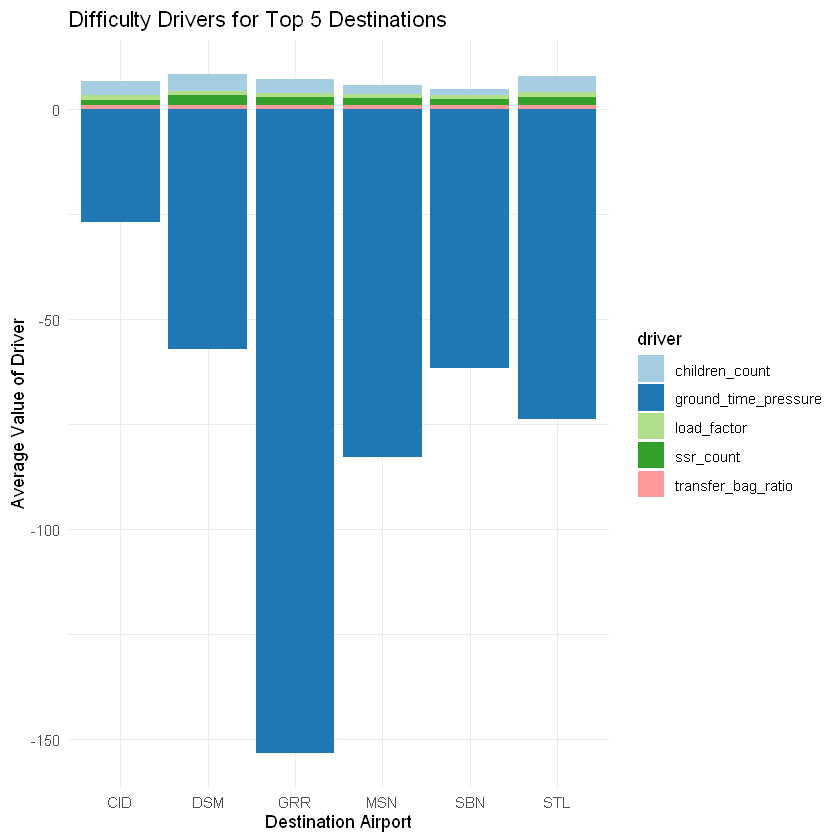

In [9]:

# PHASE 6: DEPLOYMENT (INSIGHTS)


print("[Phase 6/6] Generating Final Insights and Recommendations...")
cat("\nOperational Insights\n")

# a) Summarize difficult destinations
difficult_flights <- filter(df, difficulty_class == 'Difficult')
top_difficult_destinations <- count(difficult_flights, scheduled_arrival_station_code, sort = TRUE, name = "count") %>% top_n(5, count)
cat("1. Top 5 Most Consistently Difficult Destinations:\n")
print(top_difficult_destinations)

# b) Analyze common drivers
driver_analysis <- difficult_flights %>%
  filter(scheduled_arrival_station_code %in% top_difficult_destinations$scheduled_arrival_station_code) %>%
  group_by(scheduled_arrival_station_code) %>%
  summarise(across(all_of(difficulty_features), mean, na.rm = TRUE))

cat("\n2. Common Drivers for Top Difficult Destinations (Average Values):\n")
# CORRECTED: Only round the numeric columns for printing
driver_analysis_rounded <- driver_analysis %>%
  mutate(across(where(is.numeric), ~round(., 2)))
print(driver_analysis_rounded)


# Drivers Visualization
viz_drivers <- driver_analysis %>%
  pivot_longer(-scheduled_arrival_station_code, names_to = "driver", values_to = "value") %>%
  ggplot(aes(x = scheduled_arrival_station_code, y = value, fill = driver)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_fill_brewer(palette = "Paired") +
  labs(title = "Difficulty Drivers for Top 5 Destinations", x = "Destination Airport", y = "Average Value of Driver") +
  theme_minimal()
print(viz_drivers)

# c) Recommendations
cat("\n3. Recommendations for Better Operational Efficiency:\n")
cat("   - Proactive Resource Allocation: Use the daily 'Difficult' classification to pre-allocate staff for flights to top difficult destinations.\n")
cat("   - Targeted SSR Support: High SSR counts are a key complexity driver. An alert system for the gate manager on these flights could streamline boarding.\n")
cat("   - Baggage Hotspot Management: Focus on optimizing baggage handling for flights with a high transfer bag ratio, especially at hub airports.\n")
cat("   - Gate and Turnaround Strategy: Assign flights with high ground time pressure to efficient gates and ensure turnaround crews are pre-briefed.\n")
cat("   - Continuous Monitoring: Regularly update and monitor the 'Flight Difficulty Score' to adapt to changing operational conditions.\n")